In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [16]:
ticker = yf.Ticker('AAPL')
df = ticker.history(start='2019-01-01', end='2022-10-01', interval = "1d")

In [17]:
df = df.resample("D").mean().ffill()

Для прогнозированию временного ряда на год вперед выбираем Prophet. Т.к.:
1. Позволяет легко, быстро и дешево получить качественнной прогноз.
2. Полностью автоматический. Нет необходимости подбирать гиперпараметры
3. Хорошо подходит для улавливания трендов при долгосрочном прогнозе
4. Удобно анализировать изменения целевой переменной в разрезе кого-либо периода - недели, года...

In [18]:
from prophet import Prophet

In [19]:
hvplot.plot(df.Close, width=800, height=400, title='AAPL Цена закрытия 2019-2022', grid=True, kind='line', yformatter='%.0f')

:Curve   [Date]   (Close)

In [20]:
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-09-26,149.660004,153.770004,149.639999,150.770004,93339400.0,0.0,0.0
2022-09-27,152.740005,154.720001,149.949997,151.759995,84442700.0,0.0,0.0
2022-09-28,147.639999,150.639999,144.839996,149.839996,146691400.0,0.0,0.0
2022-09-29,146.100006,146.720001,140.679993,142.479996,128138200.0,0.0,0.0
2022-09-30,141.279999,143.100006,138.000000,138.199997,124705400.0,0.0,0.0


In [21]:
df.reset_index(inplace=True)
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']

In [22]:
predictions = 365

df.ds = df.ds.apply(lambda x: x.replace(tzinfo=None))

In [23]:
train_df = df[:-predictions]

In [24]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(train_df)

future = model.make_future_dataframe(periods=predictions)
future.tail()

22:00:40 - cmdstanpy - INFO - Chain [1] start processing
22:00:41 - cmdstanpy - INFO - Chain [1] done processing


,ds
1365,2022-09-26
1366,2022-09-27
1367,2022-09-28
1368,2022-09-29
1369,2022-09-30


In [25]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
1365,2022-09-26,178.998632,124.003940,221.732884,127.167463,226.551753,-0.022172,-0.022172,-0.022172,0.001292,0.001292,0.001292,-0.023463,-0.023463,-0.023463,0.0,0.0,0.0,175.029943
1366,2022-09-27,179.088500,124.515743,222.175865,126.974620,226.833953,-0.021012,-0.021012,-0.021012,0.001645,0.001645,0.001645,-0.022657,-0.022657,-0.022657,0.0,0.0,0.0,175.325483
1367,2022-09-28,179.178367,124.723541,221.703471,126.781777,227.032714,-0.020128,-0.020128,-0.020128,0.001241,0.001241,0.001241,-0.021370,-0.021370,-0.021370,0.0,0.0,0.0,175.571810
1368,2022-09-29,179.268235,125.376152,222.070069,126.590269,227.267561,-0.019203,-0.019203,-0.019203,0.000455,0.000455,0.000455,-0.019658,-0.019658,-0.019658,0.0,0.0,0.0,175.825670
1369,2022-09-30,179.358103,125.236697,223.775399,126.476183,227.418011,-0.018086,-0.018086,-0.018086,-0.000499,-0.000499,-0.000499,-0.017587,-0.017587,-0.017587,0.0,0.0,0.0,176.114235


Для оценки качества прогнозирования выбираем метрику MAPE, т.к. она хорошо интерпретируется и измеряется в процентах

In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_percentage_error(df[:predictions]['y'], forecast[:predictions]['yhat'])
print("Train MAPE {0:.2f}%".format(error))

Train MAPE 2.53%


Test MAPE 8.46%


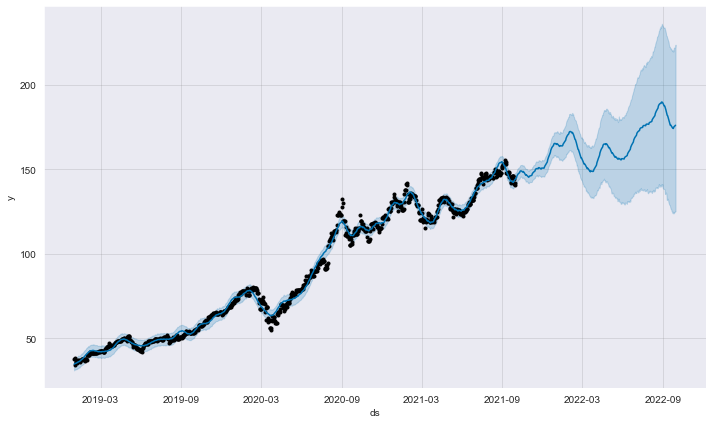

In [27]:


error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Test MAPE {0:.2f}%".format(error))
_ = model.plot(forecast)

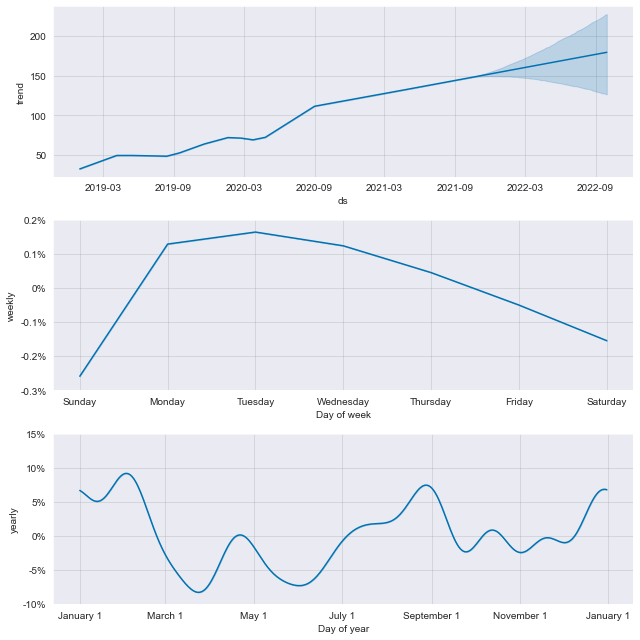

In [28]:
model.plot_components(forecast)
plt.show()

### Выводы
При прогнозе временного ряда на год вперед модель имеет точность MAPE = 8.43%. Наибольший рост цены акции в течении года - январь, февраль, август, декабрь